In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, kstest
from scipy.optimize import minimize
from scipy.special import gamma as gamma_func
from scipy.special import gamma as gamma_func
import pandas as pd
import seaborn as sns
import scipy.special as sp
import scipy.optimize as opt
import scipy.integrate as spi
import time
from google.colab import files
import statsmodels.api as sm


## I. Génération des données

In [ ]:
beta = 1 /(np.sqrt(5)*np.pi)
phi0 = 0.7
sigma0_sq = 0.3

def simulation_donnees (nb_sim = 1000 ,beta =beta, graine=103):
  # 1. Simulation des données
  np.random.seed(graine)
  n = nb_sim

  mu = 0
  var_log_eps2 = (beta ** 2) * (np.pi ** 2) / 2

  # Génération des bruits
  xi = np.random.normal(0, 1, n)
  eta = np.random.normal(0, np.sqrt(sigma0_sq), n)

  # Simulation du processus X (AR(1))
  X = np.zeros(n)
  X[0] = np.random.normal(0, np.sqrt(sigma0_sq / (1 - phi0 ** 2)))

  for i in range(1, n):
      X[i] = mu + phi0 * X[i - 1] + eta[i]

  # Construction des données Y
  Y = X + beta * np.log(xi ** 2) - beta * (-1.27)
  log_khi_sample =beta * np.log(xi ** 2)
  return Y, X, log_khi_sample


In [ ]:
beta

np.float64(0.1423525086834354)

In [ ]:
Y, X, log_khi_sample = simulation_donnees (nb_sim = 2000 ,graine=102)


## II. On visualise les données



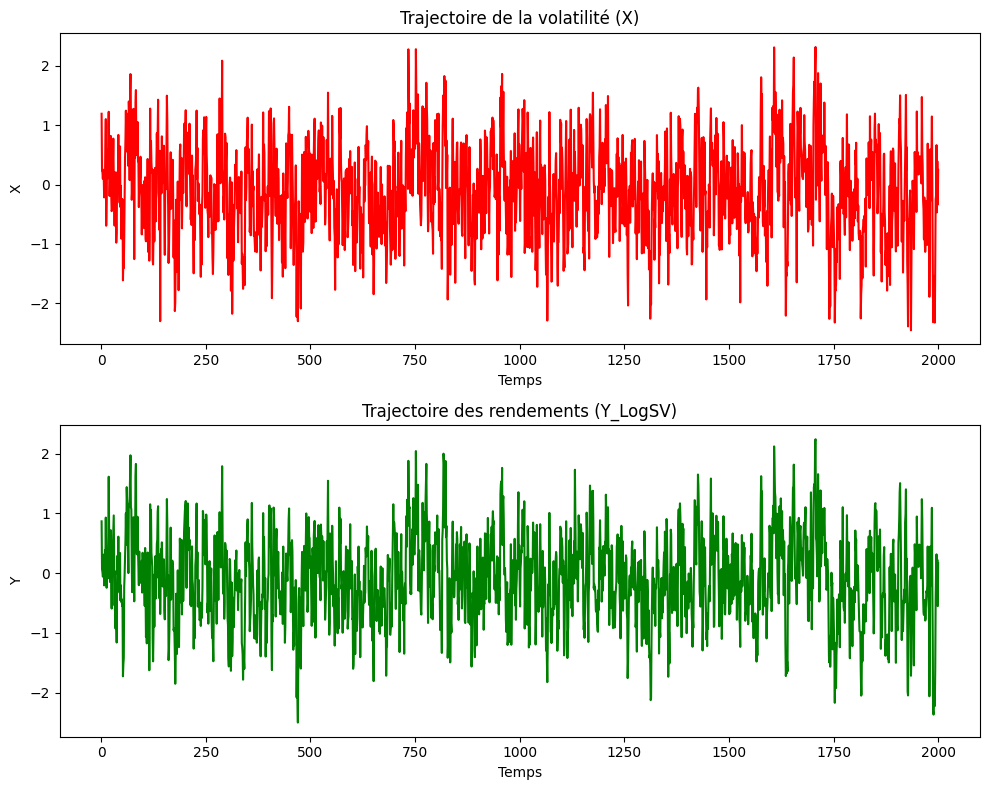

In [ ]:
def afficher_graphiques(Y, X):
    n = len(X)
    data_plot = pd.DataFrame({
        'Time': np.arange(1, n + 1),
        'Volatility': X,
        'Log_SV': Y
    })

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Graphique de X
    ax1.plot(data_plot['Time'], X, color='red')
    ax1.set_title('Trajectoire de la volatilité (X)')
    ax1.set_xlabel('Temps')
    ax1.set_ylabel('X')

    # Graphique de Y
    ax2.plot(data_plot['Time'], Y, color='green')
    ax2.set_title('Trajectoire des rendements (Y_LogSV)')
    ax2.set_xlabel('Temps')
    ax2.set_ylabel('Y')

    plt.tight_layout()
    plt.show()
afficher_graphiques(X,Y)

In [ ]:
phi =0.674328
sigma0_sq =	0.270177

In [ ]:
Y, X_2, log_khi_sample = simulation_donnees (nb_sim = 2000 ,graine=102)

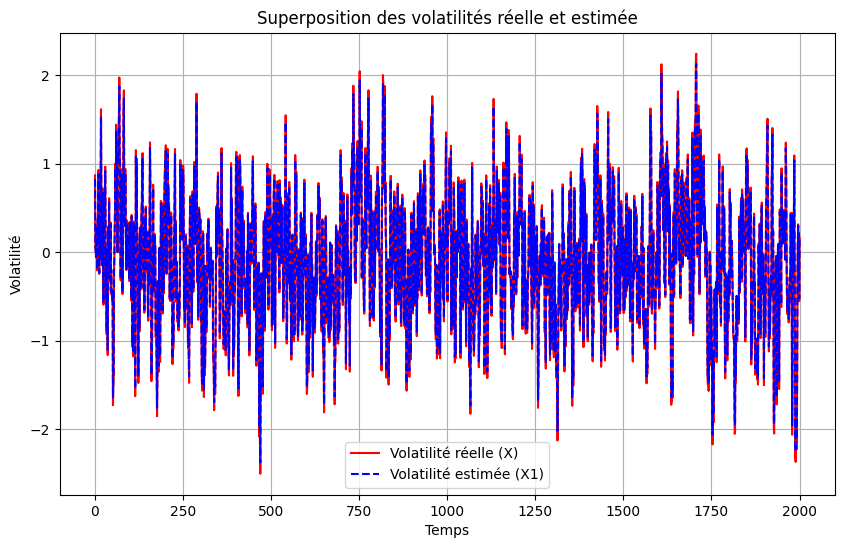

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def afficher_volatilites_superposees(X, X1):
    """
    Affiche les trajectoires des volatilités estimées et réelles superposées.

    Paramètres :
        X (array-like) : Volatilité réelle.
        X1 (array-like) : Volatilité estimée.
    """
    n = len(X)
    data_plot = pd.DataFrame({
        'Time': np.arange(1, n + 1),
        'Volatility_Real': X,
        'Volatility_Estimated': X1
    })

    plt.figure(figsize=(10, 6))

    # Tracé des volatilités superposées
    plt.plot(data_plot['Time'], data_plot['Volatility_Real'], color='red', label="Volatilité réelle (X)")
    plt.plot(data_plot['Time'], data_plot['Volatility_Estimated'], color='blue', linestyle='--', label="Volatilité estimée (X1)")

    # Ajout du titre et des labels
    plt.title('Superposition des volatilités réelle et estimée')
    plt.xlabel('Temps')
    plt.ylabel('Volatilité')
    plt.legend()
    plt.grid()

    # Affichage du graphique
    plt.show()

# Exemple d'appel de la fonction
afficher_volatilites_superposees(X, X_2)


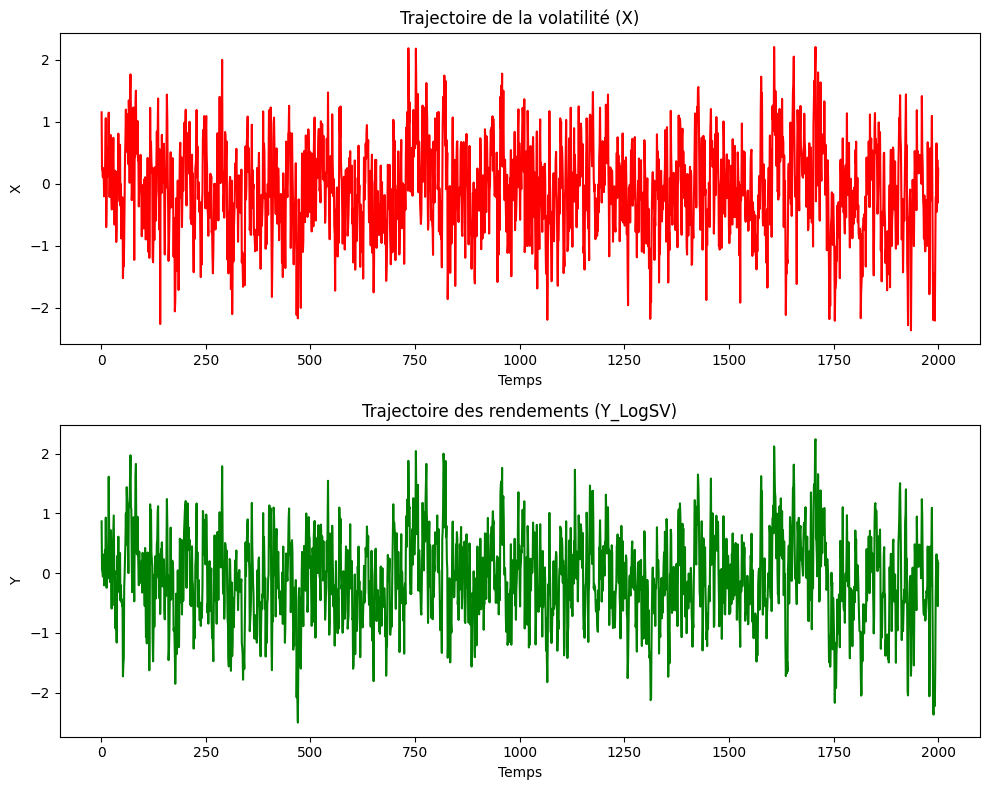

In [ ]:
def afficher_graphiques(Y, X):
    n = len(X)
    data_plot = pd.DataFrame({
        'Time': np.arange(1, n + 1),
        'Volatility': X,
        'Log_SV': Y
    })

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Graphique de X
    ax1.plot(data_plot['Time'], X, color='red')
    ax1.set_title('Trajectoire de la volatilité (X)')
    ax1.set_xlabel('Temps')
    ax1.set_ylabel('X')

    # Graphique de Y
    ax2.plot(data_plot['Time'], Y, color='green')
    ax2.set_title('Trajectoire des rendements (Y_LogSV)')
    ax2.set_xlabel('Temps')
    ax2.set_ylabel('Y')

    plt.tight_layout()
    plt.show()
afficher_graphiques(X,Y)

## III. Comparaison de la densité empiriques des erreurs avec celle théorique assumée par l'estimation par QML

Dans la méthode QML , on approche la loi log_khi deux du modèle linéarisé de Taylor par une loi normale d'espérance et de variance correspondante à celle de la log_khi deux qui est la vrai loi

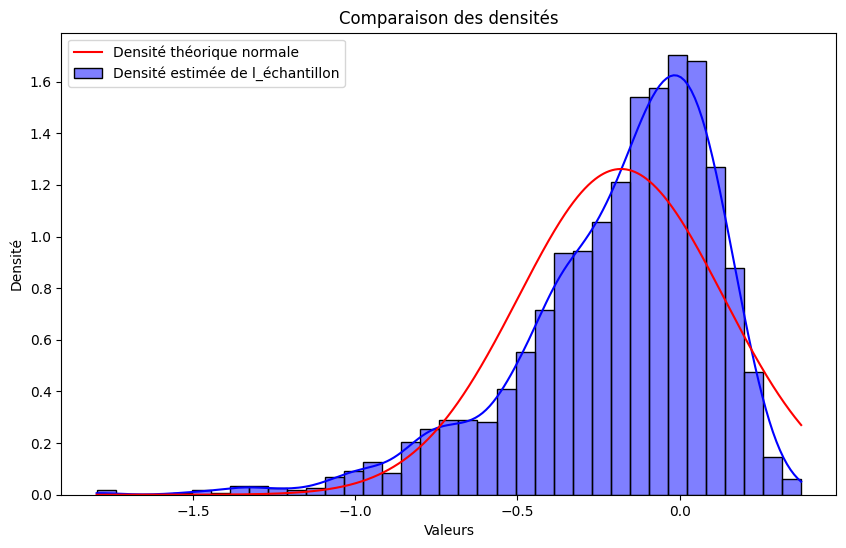

In [ ]:
def tracer_densites(log_khi_sample, beta= beta):
    plt.figure(figsize=(10, 6))

    # Histogramme de l'échantillon log_khi_sample
    sns.histplot(log_khi_sample, kde=True, stat='density', color='blue', label='Densité estimée de l_échantillon')

    # Densité théorique
    x = np.linspace(min(log_khi_sample), max(log_khi_sample), 1000)
    densite_theorique = norm.pdf(x, loc=-1.27 * beta, scale=np.sqrt((beta ** 2) * (np.pi ** 2) / 2))
    plt.plot(x, densite_theorique, color='red', label='Densité théorique normale')

    plt.title('Comparaison des densités')
    plt.xlabel('Valeurs')
    plt.ylabel('Densité')
    plt.legend()
    plt.show()

tracer_densites(log_khi_sample, beta= beta)

#### III.1. Comparaison de la distribution empirique des residus avec celle supposée dans le cadre du QML

Nous allons effectuer un test de Kolmogorov-Smirnov pour comparer l'échantillon log_khi_sample à la loi normale théorique définie par :

Moyenne : −1.27×β et de
Variance :
𝛽
2
×
𝜋
2
/
2


In [ ]:
def KS_test(log_khi_sample,beta):
   moyenne_theorique = -1.27 * beta
   ecart_type_theorique = np.sqrt((beta ** 2) * (np.pi ** 2) / 2)
   test_ks = kstest(log_khi_sample, 'norm', args=(moyenne_theorique, ecart_type_theorique))

   print(f"\nRésultat du test de Kolmogorov-Smirnov :")
   print(f"Statistique KS : {test_ks.statistic}")
   print(f"p-value : {test_ks.pvalue}")
   if test_ks.pvalue < 0.05:
      print("Les données ne suivent pas une distribution normale.")
   else:
      print("Les données suivent une distribution normale.")
KS_test(log_khi_sample,beta)


Résultat du test de Kolmogorov-Smirnov :
Statistique KS : 0.08423194247141241
p-value : 8.573228068563152e-13
Les données ne suivent pas une distribution normale.


Ainsi, l'estimation des paramètres du modèle log SV de taylor par la méthode QML peut être inéfficiente. En effet, la méthode repose sur une maximisation d'une vraisemblance approximée, qui peut s'averer être fausse comme c'est le cas avec notre jeu de données

### IV. Contrast estimator

In [ ]:
# Fonction pour calculer f_xi_star(x)
def f_xi_star(x, beta):
    E = -1.27 * beta
    term = (1 / np.sqrt(np.pi)) * 2**(1j * beta * x) * sp.gamma(0.5 + 1j * beta * x) * np.exp(-1j * E * x)
    return term

    # Fonction pour calculer u_{l_theta}(y)
def u_l_theta(y, phi, gamma, beta):
    E = -1.27 * beta
    z = 0.5 + 1j * beta * y  # Argument complexe pour la fonction gamma

    # Calcul de Gamma(1/2 + i * beta * y)
    gamma_z = sp.gamma(z)  # Utilisation de sp.gamma pour les arguments complexes

    # Termes de la fonction de déconvolution
    term1 = -1j * phi * y * (gamma**2) * np.exp(-0.5 * (y**2) * (gamma**2))
    term2 = 2 * np.exp(-1j * E * y) * (2**(1j * beta * y)) * gamma_z * np.sqrt(np.pi)

    # Résultat final
    return term1 / term2


# Fonction pour calculer l'inverse de la transformée de Fourier de u_l_theta
def inverse_fourier_ul_theta(y, phi, gamma, beta):
    # Fonction à intégrer
    integrand = lambda t: np.exp(1j * y * t) * u_l_theta(t, phi, gamma, beta)

    # Intégration numérique sur l'intervalle [-15, 15]
    result, _ = spi.quad(lambda t: np.real(integrand(t)), -15, 15)
    return result


# Fonction pour calculer le critère empirique
def critere_empirique(theta, Y, beta):
    phi, sigma_sq = theta
    gamma = np.sqrt(sigma_sq / (1 - phi**2))

    # Terme ||l_theta||^2 (réel)
    norm_l_theta_sq = ((phi**2) * gamma) / (4 * np.sqrt(np.pi))

    # Terme somme des Y_{i+1} u_{l_theta}^*(Y_i) (complexe)
    sum_term = 0
    for i in range(len(Y) - 1):
        u_star = inverse_fourier_ul_theta(Y[i], phi, gamma, beta)
        sum_term += Y[i+1] * np.real(u_star)

    # Critère empirique (convertir en réel)
    return norm_l_theta_sq - (2 / len(Y)) * sum_term


In [ ]:
# Plage d'initialisation pour theta
theta_min = [-0.9, 0.1]
theta_max = [0.9, 1.0]

# Fonction objectif pour la minimisation
objective_function = lambda theta: critere_empirique(theta, Y, beta)

# Minimisation avec L-BFGS-B
start_time_contrast = time.time()
result = opt.minimize(
    objective_function,
    x0=[0.5, 0.2],  # Initialisation arbitraire
    bounds=[(-0.9, 0.9), (0.1, 1)],
    method="L-BFGS-B"
)
time_contrast = time.time() - start_time_contrast
# Paramètres estimés
phi_hat, sigma_sq_hat = result.x

# Affichage des résultats
print(f"Paramètres estimés :")
print(f"phi_hat = {phi_hat:.6f}")
print(f"sigma_sq_hat = {sigma_sq_hat:.6f}")

Paramètres estimés :
phi_hat = 0.645829
sigma_sq_hat = 0.318526


In [ ]:
time_contrast

159.69325995445251

In [ ]:
len(Y)

2000

In [ ]:
import numpy as np
import scipy.optimize as opt
import time
import pandas as pd

# Définition de la plage d'initialisation pour theta
theta_min = np.array([-0.9, 0.1])
theta_max = np.array([0.9, 1.0])

# Nombre d'initialisations
num_initializations = 10

# Fonction objectif (exemple, à remplacer par ta fonction réelle)
def objective_function(theta):
    return critere_empirique(theta, Y, beta)  # À définir

# Stockage des résultats
results = []

for _ in range(num_initializations):
    # Générer une initialisation aléatoire
    theta_init = np.random.uniform(theta_min, theta_max)

    # Optimisation avec L-BFGS-B
    start_time = time.time()
    result = opt.minimize(
        objective_function,
        x0=theta_init,
        bounds=[(-0.9, 0.9), (0.1, 1.0)],
        method="L-BFGS-B"
    )
    elapsed_time = time.time() - start_time

    # Stocker les résultats
    phi_hat, sigma_sq_hat = result.x
    results.append([theta_init[0], theta_init[1], phi_hat, sigma_sq_hat, elapsed_time])

# Convertir en DataFrame
df_results = pd.DataFrame(
    results,
    columns=["Initial phi", "Initial sigma²", "Estimation phi_hat", "Estimation sigma²_hat", "Temps (s)"]
)

# Affichage simple
df_results.head() # Affiche les 5 premières lignes


,Initial phi,Initial sigma²,Estimation phi_hat,Estimation sigma²_hat,Temps (s)
0,0.487074,0.502688,0.645775,0.318586,130.391163
1,0.598320,0.782204,0.645763,0.318595,160.529121
2,-0.194280,0.455881,0.645825,0.318527,170.516380
3,0.522134,0.292264,0.645832,0.318524,143.208978
4,-0.482038,0.213849,0.645825,0.318531,190.018799


In [ ]:
df_results

,Initial phi,Initial sigma²,Estimation phi_hat,Estimation sigma²_hat,Temps (s)
0,0.487074,0.502688,0.645775,0.318586,130.391163
1,0.598320,0.782204,0.645763,0.318595,160.529121
2,-0.194280,0.455881,0.645825,0.318527,170.516380
3,0.522134,0.292264,0.645832,0.318524,143.208978
4,-0.482038,0.213849,0.645825,0.318531,190.018799
5,-0.550501,0.131804,0.645833,0.318517,200.041326
6,0.285543,0.438107,0.645824,0.318531,157.408065
7,-0.221973,0.726323,0.645834,0.318525,185.894376
8,-0.836078,0.400071,0.645833,0.318517,156.733927
9,0.371081,0.208769,0.645828,0.318528,154.607161


In [ ]:
import numpy as np
import scipy.optimize as opt
import time
import pandas as pd

# Fonction de log-vraisemblance basée sur le filtre de Kalman
def kalman_filter(y_t, theta, beta):
    phi, sigma2, mu = theta
    sigma = np.sqrt(sigma2)
    n = len(y_t)
    var_log_eps2 = (beta**2) * (np.pi**2) / 2

    x_hat = np.zeros(n)
    P = np.zeros(n)

    x_hat[0] = mu / (1 - phi)
    P[0] = sigma2 / (1 - phi**2)

    v_t = np.zeros(n)
    F_t = np.zeros(n)
    rap_t = np.zeros(n)

    for t in range(1, n):
        x_hat_pred = mu + phi * x_hat[t-1]
        P_pred = phi**2 * P[t-1] + sigma2

        v_t[t] = y_t[t] - x_hat_pred
        F_t[t] = P_pred + var_log_eps2
        rap_t[t] = (v_t[t]**2) / F_t[t]

        K_t = P_pred / F_t[t]
        x_hat[t] = x_hat_pred + K_t * v_t[t]
        P[t] = (1 - K_t) * P_pred

    return v_t[1:], F_t[1:], rap_t[1:]

# Fonction de log-vraisemblance QML
def qml_log_likelihood(theta, y_t, beta):
    v_t, F_t, rap_t = kalman_filter(y_t, theta, beta)
    n = len(v_t)
    log_likelihood = -(n / 2) * np.log(2 * np.pi) - 0.5 * np.sum(np.log(F_t)) - 0.5 * np.sum(rap_t)
    return -log_likelihood

# Appliquer l'estimation QML sur les valeurs initiales de df_results
results_qml = []

for index, row in df_results.iterrows():
    initial_phi = row["Initial phi"]
    initial_sigma_sq = row["Initial sigma²"]

    start_time_qml = time.time()
    result_qml = opt.minimize(
        qml_log_likelihood,
        x0=[initial_phi, initial_sigma_sq, 0.1],  # Inclure mu initial
        args=(Y, beta),
        bounds=[(-0.9, 0.9), (0.1, 1), (-0.9, 0.9)]
    )
    time_qml = time.time() - start_time_qml

    phi_hat_qml, sigma_sq_hat_qml, mu_hat_qml = result_qml.x
    results_qml.append([initial_phi, initial_sigma_sq, phi_hat_qml, sigma_sq_hat_qml, mu_hat_qml, time_qml])

# Convertir en DataFrame
df_results_qml = pd.DataFrame(
    results_qml,
    columns=["Initial phi", "Initial sigma²", "phi_hat_qml", "sigma²_hat_qml", "mu_hat_qml", "Temps (s)"]
)

# Affichage simple des 5 premières lignes
df_results_qml.head()


,Initial phi,Initial sigma²,phi_hat_qml,sigma²_hat_qml,mu_hat_qml,Temps (s)
0,0.487074,0.502688,0.674329,0.270178,-0.032767,0.404977
1,0.598320,0.782204,0.674328,0.270178,-0.032767,0.439862
2,-0.194280,0.455881,0.674328,0.270178,-0.032767,0.343350
3,0.522134,0.292264,0.674328,0.270178,-0.032767,0.205035
4,-0.482038,0.213849,0.674327,0.270178,-0.032768,0.326630


In [ ]:
df_results_qml

,Initial phi,Initial sigma²,phi_hat_qml,sigma²_hat_qml,mu_hat_qml,Temps (s)
0,0.487074,0.502688,0.674329,0.270178,-0.032767,0.404977
1,0.598320,0.782204,0.674328,0.270178,-0.032767,0.439862
2,-0.194280,0.455881,0.674328,0.270178,-0.032767,0.343350
3,0.522134,0.292264,0.674328,0.270178,-0.032767,0.205035
4,-0.482038,0.213849,0.674327,0.270178,-0.032768,0.326630
5,-0.550501,0.131804,0.674328,0.270178,-0.032767,0.284304
6,0.285543,0.438107,0.674328,0.270178,-0.032767,0.188806
7,-0.221973,0.726323,0.674328,0.270178,-0.032767,0.238221
8,-0.836078,0.400071,0.674325,0.270181,-0.032762,0.364788
9,0.371081,0.208769,0.674328,0.270178,-0.032767,0.204247


## IV. Mise en oeuvre de l'estimation des paramètres par QML

In [ ]:
def kalman_filter(y_t, theta, beta):
    phi, sigma2, mu = theta
    sigma = np.sqrt(sigma2)
    n = len(y_t)
    var_log_eps2 = (beta**2) * (np.pi**2) / 2

    x_hat = np.zeros(n)
    P = np.zeros(n)

    x_hat[0] = mu / (1 - phi)
    P[0] = sigma2 / (1 - phi**2)

    v_t = np.zeros(n)
    F_t = np.zeros(n)
    rap_t = np.zeros(n)

    for t in range(1, n):
        x_hat_pred = mu + phi * x_hat[t-1]
        P_pred = phi**2 * P[t-1] + sigma2

        v_t[t] = y_t[t] - x_hat_pred
        F_t[t] = P_pred + var_log_eps2
        rap_t[t] = (v_t[t]**2) / F_t[t]

        K_t = P_pred / F_t[t]
        x_hat[t] = x_hat_pred + K_t * v_t[t]
        P[t] = (1 - K_t) * P_pred

    return v_t[1:], F_t[1:], rap_t[1:]

def qml_log_likelihood(theta, y_t, beta):
    v_t, F_t, rap_t = kalman_filter(y_t, theta, beta)
    n = len(v_t)
    log_likelihood = -(n / 2) * np.log(2 * np.pi) - 0.5 * np.sum(np.log(F_t)) - 0.5 * np.sum(rap_t)
    return -log_likelihood

start_time_qml = time.time()
result_qml = opt.minimize(
    qml_log_likelihood,
    x0=[0.5, 0.2, 0.1],
    args=(Y, beta),
    bounds=[(-0.9, 0.9), (0.1, 1), (-0.9, 0.9)]
)
time_qml = time.time() - start_time_qml

phi_hat_qml, sigma_sq_hat_qml, _ = result_qml.x
phi_hat_qml, sigma_sq_hat_qml

(np.float64(0.6749656373226129), np.float64(0.24213492946139617))

In [ ]:
time_qml

0.22386956214904785

## V. Construction des métriques d'évaluation des performances

### V.1. Comparaison en terme de temps d'execution dépendamment de la taille de l'échantillon simulé.


#### V.1.1 Evaluation des performances en terme de temps d'execution du QML

In [ ]:
import time
import numpy as np
import pandas as pd
import scipy.optimize as opt

def mse(true, est):
    return (true - est)**2

def run_simulations(nb_sims, qml_log_likelihood, simulation_donnees):
    results = []  # Stocke les résultats de chaque simulation

    # Parcours des différents nombres de simulations
    for nb_sim in nb_sims:
        Y, X, log_khi_sample = simulation_donnees(nb_sim=nb_sim, graine=102)

        # Estimation par la méthode L-BFGS-B
        start_time_qml = time.time()
        result_qml = opt.minimize(
            qml_log_likelihood,
            x0=[0.5, 0.2, 0.1],
            args=(Y, beta),
            bounds=[(-0.9, 0.9), (0.1, 1), (-0.9, 0.9)]
        )
        time_qml = time.time() - start_time_qml

        phi_hat_qml, sigma_sq_hat_qml, _ = result_qml.x

        # Sauvegarde des résultats dans la liste
        results.append({
            "nb_sim": nb_sim,
            "phi_hat": phi_hat_qml,
            "sigma_sq_hat": sigma_sq_hat_qml,
            "time_exec": time_qml
        })

        # Affichage des résultats pour chaque simulation
        print(f"Paramètres estimés pour le nombre de simulation: {nb_sim}")
        print(f"phi_hat = {phi_hat_qml:.6f}")
        print(f"sigma_sq_hat = {sigma_sq_hat_qml:.6f}")
        print(f"Temps de calcul : {time_qml:.4f} secondes")
        print("-" * 40)

    # Conversion de la liste de résultats en DataFrame
    results_df = pd.DataFrame(results)
    return results_df


In [ ]:
nb_sims = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
results = run_simulations(nb_sims, qml_log_likelihood, simulation_donnees)


Paramètres estimés pour le nombre de simulation: 1000
phi_hat = 0.688002
sigma_sq_hat = 0.256013
Temps de calcul : 0.1155 secondes
----------------------------------------
Paramètres estimés pour le nombre de simulation: 1500
phi_hat = 0.692291
sigma_sq_hat = 0.256201
Temps de calcul : 0.1575 secondes
----------------------------------------
Paramètres estimés pour le nombre de simulation: 2000
phi_hat = 0.674328
sigma_sq_hat = 0.270177
Temps de calcul : 0.2234 secondes
----------------------------------------
Paramètres estimés pour le nombre de simulation: 2500
phi_hat = 0.683509
sigma_sq_hat = 0.282573
Temps de calcul : 0.2469 secondes
----------------------------------------
Paramètres estimés pour le nombre de simulation: 3000
phi_hat = 0.697236
sigma_sq_hat = 0.285236
Temps de calcul : 0.3034 secondes
----------------------------------------
Paramètres estimés pour le nombre de simulation: 3500
phi_hat = 0.695966
sigma_sq_hat = 0.300476
Temps de calcul : 0.3302 secondes
---------

In [ ]:
results.head(9)

,nb_sim,phi_hat,sigma_sq_hat,time_exec
0,1000,0.688002,0.256013,0.115458
1,1500,0.692291,0.256201,0.157523
2,2000,0.674328,0.270177,0.223391
3,2500,0.683509,0.282573,0.246853
4,3000,0.697236,0.285236,0.303379
5,3500,0.695966,0.300476,0.330202
6,4000,0.679999,0.309038,0.378651
7,4500,0.685830,0.304499,0.422398
8,5000,0.686625,0.299553,0.455607


In [ ]:
results['mse'] = (0.7 - results['phi_hat'])**2 + (0.3 - results['sigma_sq_hat'])**2
results.to_csv('results.csv', index=False)
# Téléchargement du fichier enregistré
files.download('results.csv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
results.head(9)

,nb_sim,phi_hat,sigma_sq_hat,time_exec,mse
0,1000,0.688002,0.256013,0.111200,0.002079
1,1500,0.692291,0.256201,0.154108,0.001978
2,2000,0.674328,0.270177,0.215941,0.001548
3,2500,0.683509,0.282573,0.249015,0.000576
4,3000,0.697236,0.285236,0.347398,0.000226
5,3500,0.695966,0.300476,0.327694,0.000017
6,4000,0.679999,0.309038,0.384706,0.000482
7,4500,0.685830,0.304499,0.423596,0.000221
8,5000,0.686625,0.299553,0.479274,0.000179


#### V.1.2. Evaluation des performances en terme de temps d'execution de l'estimateur par contraste

In [ ]:
import time
import numpy as np
import pandas as pd
import scipy.optimize as opt

def mse(true, est):
    return (true - est)**2

def run_simulations(nb_sims, simulation_donnees):
    results = []  # Stocke les résultats de chaque simulation

    # Parcours des différents nombres de simulations
    for nb_sim in nb_sims:
        Y, X, log_khi_sample = simulation_donnees(nb_sim=nb_sim, graine=102)

        # Estimation des paramètres par la méthode L-BFGS-B
        objective_function = lambda theta: critere_empirique(theta, Y, beta)
        start_time_contrast = time.time()
        result = opt.minimize(
            objective_function,
            x0=[0.5, 0.2],  # Initialisation arbitraire
            bounds=[(-0.9, 0.9), (0.1, 1)],
            method="L-BFGS-B"
        )
        time_contrast = time.time() - start_time_contrast
        # Paramètres estimés
        phi_hat, sigma_sq_hat = result.x

        # Sauvegarde des résultats dans la liste
        results.append({
            "nb_sim": nb_sim,
            "phi_hat": phi_hat,
            "sigma_sq_hat": sigma_sq_hat,
            "time_exec": time_contrast
        })

        # Affichage des résultats pour chaque simulation
        print(f"Paramètres estimés pour le nombre de simulation: {nb_sim}")
        print(f"phi_hat = {phi_hat:.6f}")
        print(f"sigma_sq_hat = {sigma_sq_hat:.6f}")
        print(f"Temps de calcul : {time_contrast:.4f} secondes")
        print("-" * 40)

    # Conversion de la liste de résultats en DataFrame
    results_df = pd.DataFrame(results)
    return results_df


In [ ]:
nb_sims = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
results_contrast = run_simulations(nb_sims,  simulation_donnees)

Paramètres estimés pour le nombre de simulation: 1000
phi_hat = 0.774983
sigma_sq_hat = 0.173110
Temps de calcul : 82.8277 secondes
----------------------------------------
Paramètres estimés pour le nombre de simulation: 1500
phi_hat = 0.692732
sigma_sq_hat = 0.268200
Temps de calcul : 102.9227 secondes
----------------------------------------
Paramètres estimés pour le nombre de simulation: 2000
phi_hat = 0.645829
sigma_sq_hat = 0.318526
Temps de calcul : 153.8099 secondes
----------------------------------------
Paramètres estimés pour le nombre de simulation: 2500
phi_hat = 0.684294
sigma_sq_hat = 0.290830
Temps de calcul : 191.1439 secondes
----------------------------------------
Paramètres estimés pour le nombre de simulation: 3000
phi_hat = 0.715911
sigma_sq_hat = 0.261684
Temps de calcul : 250.1354 secondes
----------------------------------------
Paramètres estimés pour le nombre de simulation: 3500
phi_hat = 0.713201
sigma_sq_hat = 0.274260
Temps de calcul : 241.5902 seconde

In [ ]:
results_contrast.head(9)

,nb_sim,phi_hat,sigma_sq_hat,time_exec
0,1000,0.774983,0.173110,82.827690
1,1500,0.692732,0.268200,102.922675
2,2000,0.645829,0.318526,153.809880
3,2500,0.684294,0.290830,191.143895
4,3000,0.715911,0.261684,250.135374
5,3500,0.713201,0.274260,241.590151
6,4000,0.709877,0.280405,302.857004
7,4500,0.737803,0.241394,377.747669
8,5000,0.715433,0.257824,410.995228


In [ ]:
results_contrast['mse'] = (0.7 - results_contrast['phi_hat'])**2 + (0.3 - results_contrast['sigma_sq_hat'])**2
results_contrast.to_csv('results_contrast.csv', index=False)
# Téléchargement du fichier enregistré
files.download('results_contrast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
results_contrast.head(9)

,nb_sim,phi_hat,sigma_sq_hat,time_exec,mse
0,1000,0.774983,0.173110,82.827690,0.021723
1,1500,0.692732,0.268200,102.922675,0.001064
2,2000,0.645829,0.318526,153.809880,0.003278
3,2500,0.684294,0.290830,191.143895,0.000331
4,3000,0.715911,0.261684,250.135374,0.001721
5,3500,0.713201,0.274260,241.590151,0.000837
6,4000,0.709877,0.280405,302.857004,0.000482
7,4500,0.737803,0.241394,377.747669,0.004864
8,5000,0.715433,0.257824,410.995228,0.002017


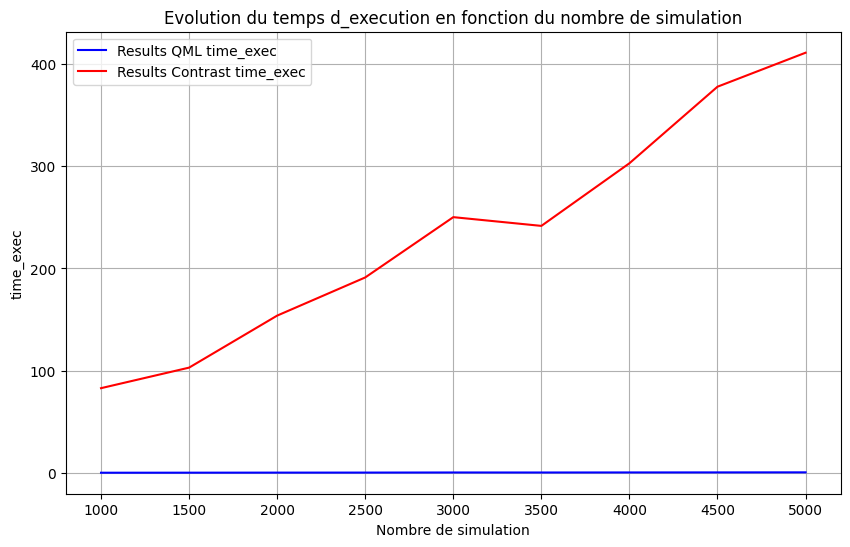

In [ ]:
# On suppose que 'mse' est une colonne présente dans chacun de tes DataFrames.
plt.figure(figsize=(10, 6))

# Tracé de 'results'
plt.plot(results['nb_sim'], results['time_exec'], label='Results QML time_exec', color='blue')

# Tracé de 'results_contrast'
plt.plot(results_contrast['nb_sim'], results_contrast['time_exec'], label='Results Contrast time_exec', color='red')

# Configuration du graphique
plt.title('Evolution du temps d_execution en fonction du nombre de simulation')
plt.xlabel('Nombre de simulation')
plt.ylabel('time_exec')
plt.legend()
plt.grid(True)
plt.show()

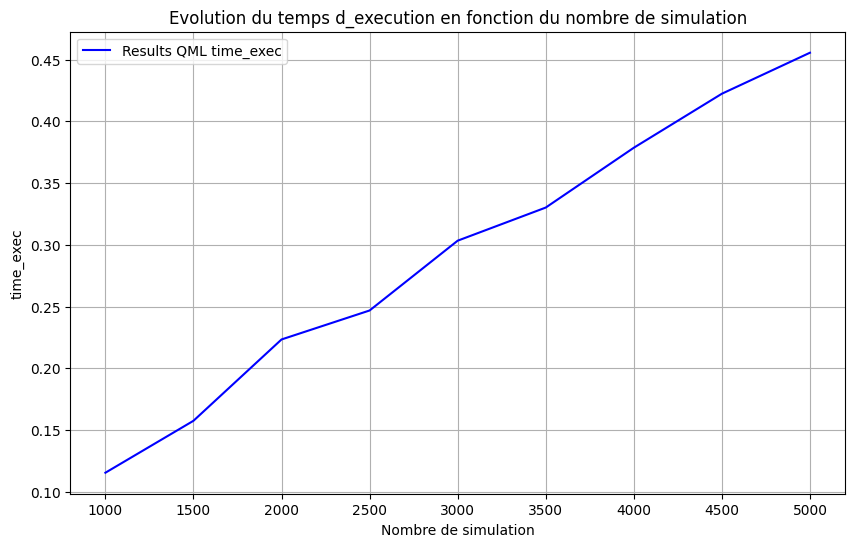

In [ ]:
# On suppose que 'mse' est une colonne présente dans chacun de tes DataFrames.
plt.figure(figsize=(10, 6))

# Tracé de 'results'
plt.plot(results['nb_sim'], results['time_exec'], label='Results QML time_exec', color='blue')

# Tracé de 'results_contrast'
#plt.plot(results_contrast['nb_sim'], results_contrast['time_exec'], label='Results Contrast time_exec', color='red')

# Configuration du graphique
plt.title('Evolution du temps d_execution en fonction du nombre de simulation')
plt.xlabel('Nombre de simulation')
plt.ylabel('time_exec')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# On quantifie l'ordre de grandeur du temps d'execution en fonction du nombre de simulation
import warning
# Récupération des données
x = results_contrast['nb_sim']
y = results_contrast['time_exec']
# Ajout de l'intercept
X = sm.add_constant(x)

#régression linéaire
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              time_exec   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     304.5
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           4.99e-07
Time:                        07:00:17   Log-Likelihood:                -37.845
No. Observations:                   9   AIC:                             79.69
Df Residuals:                       7   BIC:                             80.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.6764     15.507     -0.882      0.4

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)


<ipython-input-132-b0a205420665>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x, results.fittedvalues, label=f'Regression Linéaire: y = {results.params[1]:.4f}x + {results.params[0]:.4f}', color='blue')


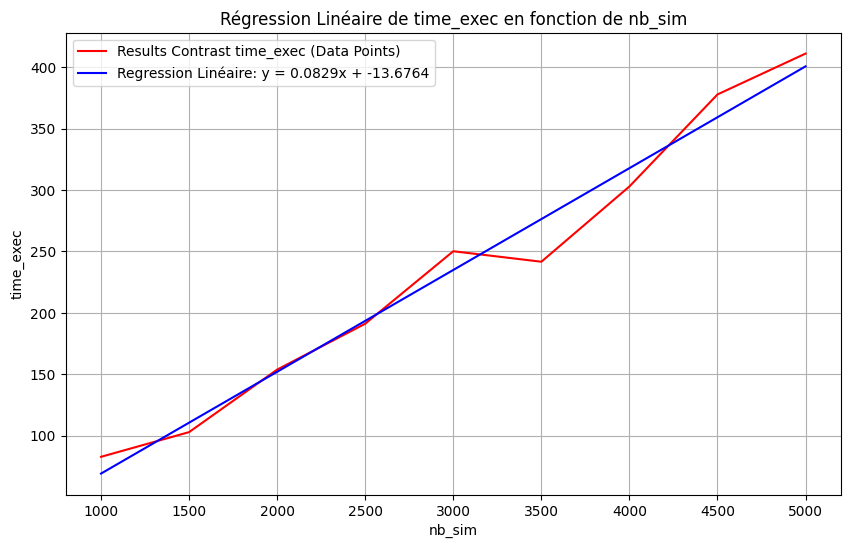

In [ ]:

# Affichage du graphique avec droite la régression
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Results Contrast time_exec (Data Points)', color='red')
plt.plot(x, results.fittedvalues, label=f'Regression Linéaire: y = {results.params[1]:.4f}x + {results.params[0]:.4f}', color='blue')
plt.title('Régression Linéaire de time_exec en fonction de nb_sim')
plt.xlabel('nb_sim')
plt.ylabel('time_exec')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import yfinance as yf
import pandas as pd

# Définition des tickers et de la période
tickers = ["^FTSE", "^GSPC"]
start_date = "2004-01-03"
end_date = "2007-01-02"

# Téléchargement des données (Close uniquement)
data = yf.download(tickers, start=start_date, end=end_date, interval="1d")["Close"]

# Renommer les colonnes pour plus de clarté
data.columns = ["FTSE", "S&P500"]




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


In [ ]:
data.head()

,FTSE,S&P500
Date,,
2004-01-05,4513.299805,1122.219971
2004-01-06,4505.200195,1123.670044
2004-01-07,4473.000000,1126.329956
2004-01-08,4494.200195,1131.920044
2004-01-09,4466.299805,1121.859985


#### V.1.2. Evolution de l'erreur en fonction du nombre de simulation pour un graine fixé

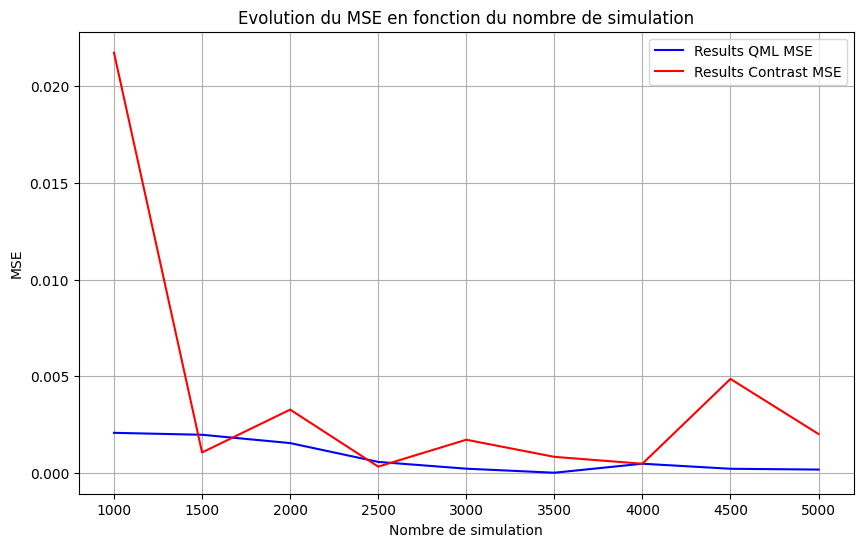

In [ ]:
# On suppose que 'mse' est une colonne présente dans chacun de tes DataFrames.
plt.figure(figsize=(10, 6))

# Tracé de 'results'
plt.plot(results['nb_sim'], results['mse'], label='Results QML MSE', color='blue')

# Tracé de 'results_contrast'
plt.plot(results_contrast['nb_sim'], results_contrast['mse'], label='Results Contrast MSE', color='red')

# Configuration du graphique
plt.title('Evolution du MSE en fonction du nombre de simulation')
plt.xlabel('Nombre de simulation')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

### V.2. Comparaison de la variablilité échantillonale pour  d'échantillon simulé des  RMSE dont la formule est donnée par:


$$
MSE = \frac{1}{N} \sum_{i=1}^{N} \left( (\phi_0 - \phi)^2 + (\sigma_0^2 - \sigma^2)^2 \right)
$$


le mse pour le qml est donné par:  0.0015736727800249846


ValueError: Could not interpret value `phi_hat` for `y`. An entry with this name does not appear in `data`.

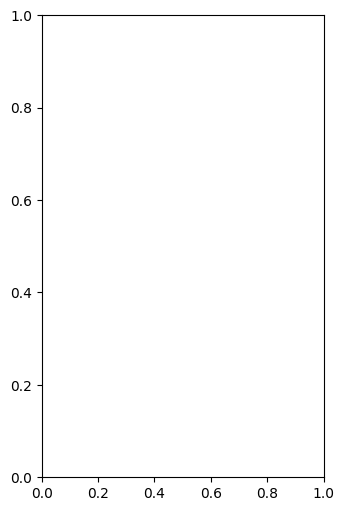

In [ ]:
import time
import numpy as np
import pandas as pd
import scipy.optimize as opt

def mse(true, est):
    return (true - est)**2

def var_echantillonale(qml_log_likelihood, simulation_donnees, n_echantillons = 100,nb_sim=2000):
    results = []  # Stocke les résultats de chaque simulation

    # Parcours des différents nombres de simulations
    for i in range(n_echantillons):
        Y, X, log_khi_sample = simulation_donnees(nb_sim=nb_sim, graine=i)

        # Estimation par la méthode L-BFGS-B
        start_time_qml = time.time()
        result_qml = opt.minimize(
            qml_log_likelihood,
            x0=[0.5, 0.2, 0.1],
            args=(Y, beta),
            bounds=[(-0.9, 0.9), (0.1, 1), (-0.9, 0.9)]
        )
        time_qml = time.time() - start_time_qml

        phi_hat_qml, sigma_sq_hat_qml, _ = result_qml.x

        # Sauvegarde des résultats dans la liste
        results.append({
            "nb_sim": nb_sim,
            "phi_hat_qml": phi_hat_qml,
            "sigma_sq_hat_qml": sigma_sq_hat_qml,
            "time_exec_qml": time_qml
        })
    # Conversion de la liste de résultats en DataFrame
    df = pd.DataFrame(results)
    df['mse'] = (0.7 - df['phi_hat'])**2 + (0.3 - df['sigma_sq_hat'])**2
    mse = df['mse'].mean()
    print("le mse pour le qml est donné par: ", mse)

    # Initialisation de la figure
    plt.figure(figsize=(8, 6))

    # Box plot pour 'phi_hat'
    plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, premier subplot
    sns.boxplot(data=df, x='nb_sim', y='phi_hat', color='skyblue')
    plt.title('Box plot de phi_hat')

    # Box plot pour 'sigma_sq_hat'
    plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, deuxième subplot
    sns.boxplot(data=df, x='nb_sim', y='sigma_sq_hat', color='lightgreen')
    plt.title('Box plot de sigma_sq_hat')

    # Ajustement des titres et affichage
    plt.tight_layout()
    plt.show()
    return df
df = var_echantillonale(qml_log_likelihood, simulation_donnees, n_echantillons = 100,nb_sim=2000)


le mse pour le contrast est donné par:  0.003510291369996296


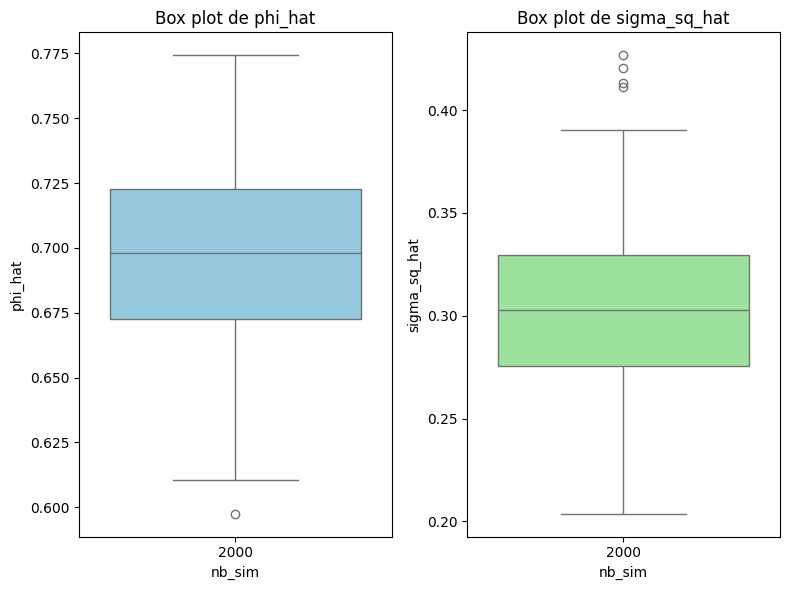

In [ ]:
import time
import numpy as np
import pandas as pd
import scipy.optimize as opt

def mse(true, est):
    return (true - est)**2

def var_echantillonale(simulation_donnees, n_echantillons = 100,nb_sim=2000):
    results = []  # Stocke les résultats de chaque simulation

    # Parcours des différents nombres de simulations
    for i in range(n_echantillons):
        Y, X, log_khi_sample = simulation_donnees(nb_sim=nb_sim, graine=i)

        # Estimation des paramètres par la méthode L-BFGS-B
        objective_function = lambda theta: critere_empirique(theta, Y, beta)
        start_time_contrast = time.time()
        result = opt.minimize(
            objective_function,
            x0=[0.5, 0.2],  # Initialisation arbitraire
            bounds=[(-0.9, 0.9), (0.1, 1)],
            method="L-BFGS-B"
        )
        time_contrast = time.time() - start_time_contrast
        # Paramètres estimés
        phi_hat, sigma_sq_hat = result.x
        # Sauvegarde des résultats dans la liste
        results.append({
            "nb_sim": nb_sim,
            "phi_hat": phi_hat,
            "sigma_sq_hat": sigma_sq_hat,
            "time_exec": time_contrast
        })
    # Conversion de la liste de résultats en DataFrame
    df = pd.DataFrame(results)
    df['mse'] = (0.7 - df['phi_hat'])**2 + (0.3 - df['sigma_sq_hat'])**2
    mse = df['mse'].mean()
    print("le mse pour le contrast est donné par: ", mse)

    # Initialisation de la figure
    plt.figure(figsize=(8, 6))

    # Box plot pour 'phi_hat'
    plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, premier subplot
    sns.boxplot(data=df, x='nb_sim', y='phi_hat', color='skyblue')
    plt.title('Box plot de phi_hat')

    # Box plot pour 'sigma_sq_hat'
    plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, deuxième subplot
    sns.boxplot(data=df, x='nb_sim', y='sigma_sq_hat', color='lightgreen')
    plt.title('Box plot de sigma_sq_hat')

    # Ajustement des titres et affichage
    plt.tight_layout()
    plt.show()
    return df
df = var_echantillonale(simulation_donnees, n_echantillons = 100,nb_sim=2000)


In [ ]:
df.to_csv('df_var_echantillonale.csv', index=False)
# Téléchargement du fichier enregistré
files.download('df_var_echantillonale.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.head()

,nb_sim,phi_hat,sigma_sq_hat,time_exec,mse
0,2000,0.698133,0.300508,0.224150,0.000004
1,2000,0.701903,0.283576,0.223915,0.000273
2,2000,0.702880,0.306770,0.185938,0.000054
3,2000,0.719487,0.279483,0.206537,0.000801
4,2000,0.704392,0.285695,0.207769,0.000224


In [ ]:
df['mse'].mean()

np.float64(0.0005348070729149801)

In [ ]:
df_var_echantillonale_2000['mse'].mean()

np.float64(0.003510291369996251)

In [ ]:
df_merged = df_var_echantillonale_2000.join(df, lsuffix='_2000', rsuffix='_df')

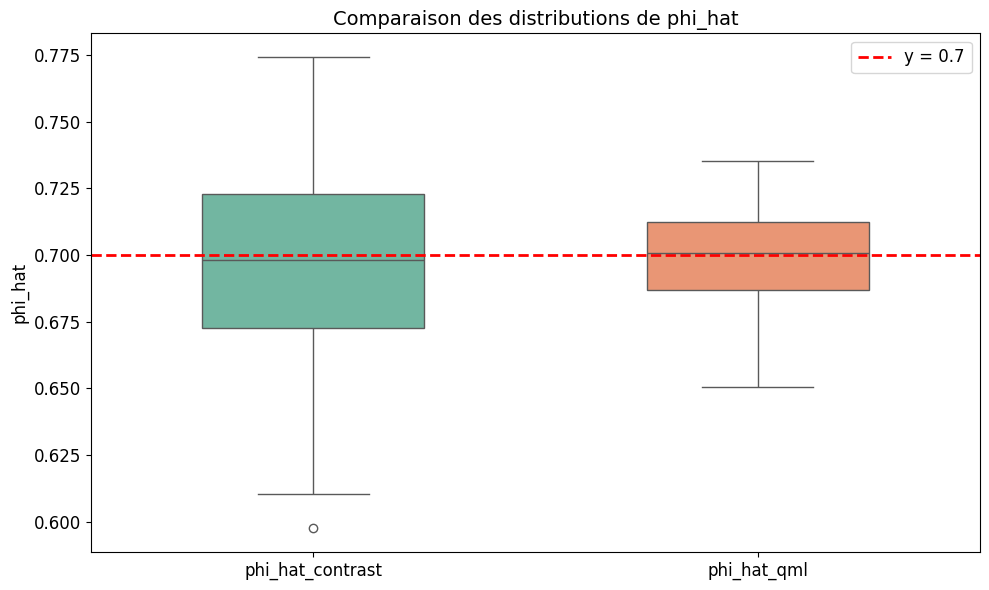

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Création de la figure avec une taille plus grande
plt.figure(figsize=(10, 6))

# Création des box plots pour phi_hat_2000 et phi_hat_df
sns.boxplot(data=[df_merged["phi_hat_2000"], df_merged["phi_hat_df"]], palette="Set2", width=0.5)

# Ajout de la ligne rouge à 0.7
plt.axhline(y=0.7, color='red', linestyle='--', linewidth=2, label="y = 0.7")

# Personnalisation du graphique
plt.xticks([0, 1], ["phi_hat_contrast", "phi_hat_qml"], fontsize=12)  # Labels sous les boxplots
plt.yticks(fontsize=12)
plt.title("Comparaison des distributions de phi_hat", fontsize=14)
plt.ylabel("phi_hat", fontsize=12)
plt.legend(fontsize=12)

# Ajuster les marges pour éviter le chevauchement
plt.tight_layout()

# Affichage du graphique
plt.show()


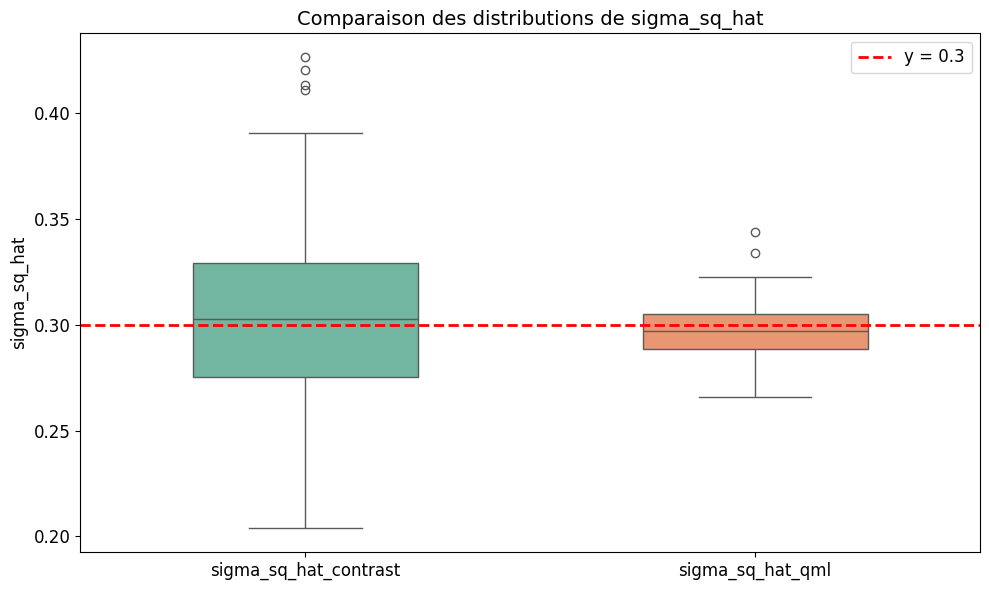

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Création de la figure avec une taille plus grande
plt.figure(figsize=(10, 6))

# Création des box plots pour phi_hat_2000 et phi_hat_df
sns.boxplot(data=[df_merged["sigma_sq_hat_2000"], df_merged["sigma_sq_hat_df"]], palette="Set2", width=0.5)

# Ajout de la ligne rouge à 0.7
plt.axhline(y=0.3, color='red', linestyle='--', linewidth=2, label="y = 0.3")

# Personnalisation du graphique
plt.xticks([0, 1], ["sigma_sq_hat_contrast", "sigma_sq_hat_qml"], fontsize=12)  # Labels sous les boxplots
plt.yticks(fontsize=12)
plt.title("Comparaison des distributions de sigma_sq_hat", fontsize=14)
plt.ylabel("sigma_sq_hat", fontsize=12)
plt.legend(fontsize=12)

# Ajuster les marges pour éviter le chevauchement
plt.tight_layout()

# Affichage du graphique
plt.show()


## Consistence de l'estimateur

In [ ]:
from google.colab import files
import pandas as pd

# Upload du fichier
uploaded = files.upload()

# Charger le fichier dans un DataFrame pandas
df = pd.read_csv("nom_du_fichier.csv")

# Afficher les premières lignes
print(df.head())


In [ ]:
import pandas as pd

# Charger le fichier dans un DataFrame pandas
df_var_echantillonale_1500 = pd.read_csv("df_var_echantillonale_1500.csv")
df_var_echantillonale_2000 = pd.read_csv("df_var_echantillonale_2000.csv")
df_var_echantillonale_2500 = pd.read_csv("df_var_echantillonale_2500.csv")
df_var_echantillonale_3000 = pd.read_csv("df_var_echantillonale_3000.csv")
df_var_echantillonale_3500 = pd.read_csv("df_var_echantillonale_3500.csv")
df_var_echantillonale_4000 = pd.read_csv("df_var_echantillonale_4000.csv")



In [ ]:
df_var_echantillonale_1500["mse"].mean()
df_var_echantillonale_2000["mse"].mean()
df_var_echantillonale_2500["mse"].mean()
df_var_echantillonale_3000["mse"].mean()
df_var_echantillonale_3500["mse"].mean()
df_var_echantillonale_4000["mse"].mean()

np.float64(0.004608093201979068)

In [ ]:
df_var_echantillonale_2000["mse"].mean()

np.float64(0.003510291369996251)

In [ ]:
df_var_echantillonale_2500["mse"].mean()

np.float64(0.0034515118852092904)

In [ ]:
df_var_echantillonale_3000["mse"].mean()

np.float64(0.002730599102996577)

In [ ]:
df_var_echantillonale_3500["mse"].mean()

np.float64(0.002271118285854028)

In [ ]:
df_var_echantillonale_4000["mse"].mean()

np.float64(0.0018508713772930928)

In [ ]:
import numpy as np
import pandas as pd

def bootstrap_ci(data, column, n_bootstrap=1000, sample_size = 500, confidence_level=0.95):
    """
    Calcule l'intervalle de confiance bootstrap pour une colonne donnée.

    Paramètres :
        data (pd.DataFrame) : Le DataFrame contenant les données.
        column (str) : Le nom de la colonne pour laquelle calculer l'IC.
        n_bootstrap (int) : Nombre de rééchantillonnages bootstrap (par défaut 1000).
        confidence_level (float) : Niveau de confiance (par défaut 95%).

    Retourne :
        (float, float) : Bornes inférieure et supérieure de l'IC.
    """
    sample_size = len(data)
    bootstrap_samples = np.random.choice(data[column], size=(n_bootstrap, sample_size), replace=True)
    bootstrap_medians = np.median(bootstrap_samples, axis=1)  # Remplace mean() par median()

    lower_bound = np.percentile(bootstrap_medians, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(bootstrap_medians, (1 + confidence_level) / 2 * 100)


    return round(lower_bound, 3), round(upper_bound, 3)


In [ ]:

# ======= Calcul des IC Bootstrap =======
ic_phi_1500 = bootstrap_ci(df_var_echantillonale_1500, 'phi_hat')
ic_sigma_sq_1500 = bootstrap_ci(df_var_echantillonale_1500, 'sigma_sq_hat')

# ======= Affichage des résultats =======
print(f"Intervalle de confiance bootstrap à 95% pour phi_hat : {ic_phi_1500}")
print(f"Intervalle de confiance bootstrap à 95% pour sigma_sq_hat : {ic_sigma_sq_1500}")


Intervalle de confiance bootstrap à 95% pour phi_hat : (np.float64(0.687), np.float64(0.707))
Intervalle de confiance bootstrap à 95% pour sigma_sq_hat : (np.float64(0.288), np.float64(0.32))


In [ ]:

# ======= Calcul des IC Bootstrap =======
ic_phi_1500 = bootstrap_ci(df, 'phi_hat')
ic_sigma_sq_1500 = bootstrap_ci(df, 'sigma_sq_hat')

# ======= Affichage des résultats =======
print(f"Intervalle de confiance bootstrap à 95% pour phi_hat : {ic_phi_1500}")
print(f"Intervalle de confiance bootstrap à 95% pour sigma_sq_hat : {ic_sigma_sq_1500}")


Intervalle de confiance bootstrap à 95% pour phi_hat : (np.float64(0.694), np.float64(0.705))
Intervalle de confiance bootstrap à 95% pour sigma_sq_hat : (np.float64(0.294), np.float64(0.3))


In [ ]:

# ======= Calcul des IC Bootstrap =======
ic_phi_2000 = bootstrap_ci(df_var_echantillonale_2000, 'phi_hat')
ic_sigma_sq_2000 = bootstrap_ci(df_var_echantillonale_2000, 'sigma_sq_hat')

# ======= Affichage des résultats =======
print(f"Intervalle de confiance bootstrap à 95% pour phi_hat : {ic_phi_2000}")
print(f"Intervalle de confiance bootstrap à 95% pour sigma_sq_hat : {ic_sigma_sq_2000}")


Intervalle de confiance bootstrap à 95% pour phi_hat : (np.float64(0.69), np.float64(0.705))
Intervalle de confiance bootstrap à 95% pour sigma_sq_hat : (np.float64(0.295), np.float64(0.313))


In [ ]:
df_var_echantillonale_2000['mse'].mean()

np.float64(0.003510291369996251)